## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
\begin{equation}
\begin{split}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2) & \qquad\text{Output of the network}
\end{split}
\end{equation}

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data floing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_1\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.

There is nice article about taking derivative over vectors and vector chain rule: https://explained.ai/matrix-calculus/ if someone don't have experience with suchr calculus.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

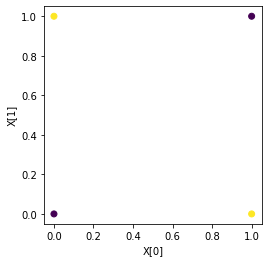

In [2]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [8]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.uniform(0.0, 0.5, self.W1.shape)
        self.b1 = np.random.uniform(0.0, 0.5, self.b1.shape)
        self.W2 = np.random.uniform(0.0, 0.5, self.W2.shape)
        self.b2 = np.random.uniform(0.0, 0.5, self.b2.shape)

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        # print(X)
        A1 = np.matmul(X, self.W1.T) + self.b1
        # print(A1)
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # print(O1)
        # Inputs to neuron in the second layer
        A2 = np.matmul(O1, self.W2.T) + self.b2
        # print(A2)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)
        # print(O2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(
                1.0 - O2)
            # loss =  TODO cross-entropy loss
            # yyyy tu chyba nie było nic do zrobienia oprócz nawiasu zamykającego
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            # hmm
            # O2_grad = (-Y / O2) + ((1.0 - Y) / (1 - O2)) # cross-entropy loss # dL / dO_2
            # A2_grad = O2_grad * (O2 * (1.0 - O2)) # mnożenie po elementach? # dL / dA_2
            # self.b2_grad = A2_grad.sum(0)
            # self.W2_grad = TODO
            # O1_grad = TODO
            # A1_grad = TODO
            # self.b1_grad = TODO
            # self.W1_grad = TODO
            pass

        return O2, loss

In [11]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)

net.W1 = np.array([[12.0, 12.0], [12.0, 12.0]])
net.b1 = np.array([[-0, -0]])
net.b1 = np.array([[-6, -18]])
net.W2 = np.array([[12.0, -12.0]])
net.b2 = np.array([[-6]])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.0025468987091777856
XORnet([0. 1.]) = 0.9973765994735605
XORnet([1. 0.]) = 0.9973765994735605
XORnet([1. 1.]) = 0.002546898709177781


## Problem 2

In [5]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [6]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
[[0.3560281  0.49485408]
 [0.61751775 0.59285148]
 [0.67323348 0.88615274]
 [0.93472313 0.98415014]]
[[0.58807861 0.62124926]
 [0.64965379 0.64401914]
 [0.66222681 0.7080956 ]
 [0.71803252 0.72793092]]
[[0.77166267]
 [0.80721516]
 [0.83370901]
 [0.86567103]]
[[0.68388045]
 [0.69151576]
 [0.69713861]
 [0.70384413]]


AttributeError: ignored

## Problem 3

In [ ]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = TODO  # set a learning rate

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param[:] = param - alpha * getattr(
            net, param_name + "_grad"
        param[:] = TODO

after 0 steps 	loss=0.7030986613179002
after 5000 steps 	loss=0.039262771262978426
after 10000 steps 	loss=0.0112648330309782
after 15000 steps 	loss=0.006341719247904163
after 20000 steps 	loss=0.004353905250332843
after 25000 steps 	loss=0.003290179535302945
after 30000 steps 	loss=0.002631393986662781
after 35000 steps 	loss=0.002184915778143186
after 40000 steps 	loss=0.0018631892106566138
after 45000 steps 	loss=0.0016208122322581048
after 50000 steps 	loss=0.0014319432296474692
after 55000 steps 	loss=0.0012808141799311246
after 60000 steps 	loss=0.0011572694776801507
after 65000 steps 	loss=0.0010544792022085616
after 70000 steps 	loss=0.0009676844511458502
after 75000 steps 	loss=0.0008934698953391141
after 80000 steps 	loss=0.00082932229204248
after 85000 steps 	loss=0.0007733520280307468
after 90000 steps 	loss=0.0007241116137770096
after 95000 steps 	loss=0.0006804739570141409


In [ ]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.0003640859392990912
XORnet([0. 1.]) = 0.9993732130571722
XORnet([1. 0.]) = 0.9993232671323241
XORnet([1. 1.]) = 0.0008976938717558672


In [ ]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.

X3 = TODO
Y3 = TODO

for hidden_dim in [2, 3, 5, 10, 20]:
    # TODO: run a few trainings and record the fraction of successful ones
    pass

## Problem 4


## Problem 5

## Problem 6

## Problem 7